# Layer Analytics of Neural Networks


In [1]:
import os, sys, math, datetime
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model
from mltk.utils.commander import query_platform

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths

In [2]:
models_dir = initialize()

In [3]:
model_name = "mobilenetv1_0.1_224_c3_o3_000"

In [4]:
models_tf_path = f"i:/tinyml/tiny_cnn/models/{model_name}/{model_name}.h5"

In [6]:
# Configure pandas to show all columns & rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Helper Functions

In [9]:
# Helper functions


def flat_size(shape: list):
    out = 1
    for k in shape:
        out *= k

    return out

# Get the model

In [35]:
model = keras.models.load_model(models_tf_path)

In [36]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
summary = model.summary(expand_nested=True)

Model: "mobilenetv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 3)       84        
                                                                 
 batch_normalization_27 (Bat  (None, 112, 112, 3)      12        
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 112, 112, 3)       0         
                                                                 
 depthwise_conv2d_13 (Depthw  (None, 112, 112, 3)      30        
 iseConv2D)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 112, 112, 3)      

In [38]:
mltk_summary = summarize_model(model)
print(mltk_summary)

Model: "mobilenetv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 3)       84        
                                                                 
 batch_normalization_27 (Bat  (None, 112, 112, 3)      12        
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 112, 112, 3)       0         
                                                                 
 depthwise_conv2d_13 (Depthw  (None, 112, 112, 3)      30        
 iseConv2D)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 112, 112, 3)      

In [41]:
# MLTK profile model reads the mode from a path - only works for MLTK models!

# profiling_results = profile_model(models_tf_path, accelerator='MVP', build=True)

In [42]:
# Show model in local version of Netron.app
view_model(model, tflite=True, build=True)

Serving 'C:/Users/Susanne/AppData/Local/Temp/Susanne/mltk/tmp_models/model.h5' at http://localhost:8080
Stopping http://localhost:8080


In [18]:
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [43]:
models_layer_df_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv1_0.1_224_c3_o3_000/mobilenetv1_0.1_224_c3_o3_000_layers.pkl')

# Get details from the different layers of the model

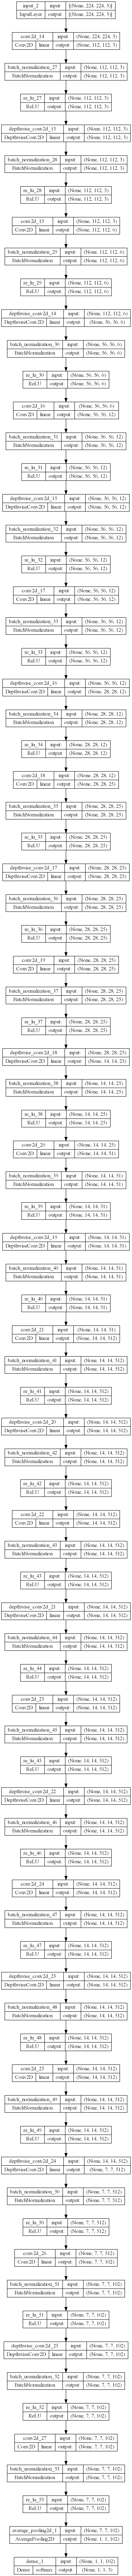

In [44]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Layer Metrics Helper Functions

In [45]:
def Conv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/conv.py
    """

    if isinstance(layer, keras.layers.Conv2D):
        _, _, _, in_depth = layer.input_shape  # layer.input_data.shape
        _, out_h, out_w, out_depth = layer.output_shape  # layer.output_data.shape
    else:
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    name = layer.name
    macs = w_h * w_w * in_depth * out_w * out_h * out_depth
    ops = macs * 2

    if layer.use_bias:
        ops += out_w * out_h * out_depth

    return (name, macs, ops)

In [46]:
def DepthwiseConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """

    # if isinstance(layer, TfliteDepthwiseConv2dLayer):
    #     _, _, _, in_depth = layer.input_data.shape
    #     _, out_h, out_w, out_depth = layer.output_data.shape

    # else: keras.layers.DepthwiseConv2D
    if isinstance(layer, keras.layers.DepthwiseConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    depth_multiplier = out_depth // in_depth

    name = layer.name
    macs = w_h * w_w * depth_multiplier * in_depth * out_w * out_h
    ops = macs * 2

    if layer.use_bias:
        ops += depth_multiplier * in_depth * out_w * out_h

    return (name, macs, ops)

In [47]:
def SeparableConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """
    name = layer.name
    if isinstance(layer, keras.layers.SeparableConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    else:
        return (name, "mac_error", "ops_error")

    w_h, w_w = layer.kernel_size

    macs_depth = w_h * w_w * in_depth * out_w * out_h
    macs_point = in_depth * out_w * out_h * out_depth
    macs = macs_depth + macs_point
    ops = macs * 2

    if layer.use_bias:
        ops += in_depth * out_w * out_h  # for depthwise convolution
        ops += (
            out_w * out_h * out_depth
        )  # for pointwise convolution ## TODO: check the calculations

    return (name, macs, ops)

In [48]:
def Dense_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/dense.py
    """

    if isinstance(layer, keras.layers.Dense):
        bias_ops = 0
        # if isinstance(layer, TfliteFullyConnectedLayer):
        #     in_depth = layer.input_data.shape[-1]
        #     out_depth = layer.output_data.shape[-1]
        #     if layer.use_bias:
        #         bias_ops = layer.outputs[0].shape.flat_size
        # else:
        in_depth = layer.input_shape[-1]
        out_depth = layer.output_shape[-1]
        if layer.use_bias:
            bias_ops = flat_size(layer.output_shape[1:])

        name = layer.name
        macs = in_depth * out_depth
        ops = macs * 2 + bias_ops

    return (name, macs, ops)

In [49]:
def AveragePooling2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/pooling.py
    """

    if isinstance(layer, keras.layers.AveragePooling2D):
        f_h, f_w = layer.pool_size
        name = layer.name
        # if isinstance(layer, KerasLayer):
        output_shape = layer.output_shape
        # else:
        #     output_shape = layer.outputs[0].shape

        ops = flat_size(output_shape[1:]) * (f_h * f_w + 1)  # + 1 for the division

    return (name, ops)

In [50]:
def calculate_no_activations(layer):
    if isinstance(
        layer, (keras.layers.Conv2D, keras.layers.Dense, keras.layers.DepthwiseConv2D)
    ):  # , )):keras.layers.Input
        # if isinstance(layer, (keras.layers.Conv2D)):
        # if isinstance(layer, (keras.layers.DepthwiseConv2D)):
        # if isinstance(layer, (keras.layers)):
        if layer.data_format == "channels_first":
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, out_h, out_w, out_depth = layer.output_shape

        return out_h * out_w * out_depth

    else:
        return 0

In [51]:
acts = calculate_no_activations(model.layers[4])
print(acts)

37632


In [52]:
def print_layer_config(layer, layer_type):
    if isinstance(layer, layer_type):
        print(f"  Layer: {type(layer)}")
        print(layer.get_config())
        print()
    else:
        pass
    return layer.layer_config

In [53]:
layer_list = []
for i, layer in enumerate(model.layers):
    layer_stats = {}
    layer_stats["index"] = i
    layer_stats["name"] = layer.name
    layer_stats["layer_type"] = type(layer)  # TODO: find a better representation
    layer_stats["input_shape"] = layer.input_shape
    layer_stats["output_shape"] = layer.output_shape
    layer_stats["dtype"] = layer.compute_dtype
    layer_stats["params"] = layer.count_params()
    layer_stats["variables"] = len(layer.variables)
    try:
        layer_stats["weights_shape"] = layer.weights[0].shape
        layer_stats["weights_name"] = layer.weights[0].name
        layer_stats["weights_dtype"] = layer.weights[0].dtype
        layer_stats["#_activations"] = calculate_no_activations(layer)
    except:
        layer_stats["weights_shape"] = 0
        layer_stats["weights_name"] = 0
        layer_stats["weights_dtype"] = 0
        layer_stats["#_activations"] = 0

    layer_config = layer.get_config()

    # Set default values for parameters that are not present in each layer
    layer_stats["OPS"] = 0
    layer_stats["MACS"] = 0
    layer_stats["filters"] = 0
    layer_stats["trainable"] = 0
    layer_stats["kernel_size"] = 0
    layer_stats["strides"] = 0
    layer_stats["padding"] = 0
    layer_stats["dilation_rate"] = 0
    layer_stats["groups"] = 0
    layer_stats["activation"] = 0
    layer_stats["use_bias"] = 0
    layer_stats["data_format"] = 0

    # if isinstance(layer, keras.layers.InputLayer):
    #     print(f"  Layer: {type(layer)}")
    #     print(layer_config)
    #     print()

    if isinstance(layer, keras.layers.Conv2D):
        # print(f"  Layer: {type(layer)}")
        # print(layer_config)
        # print()
        name, macs, ops = Conv2D_MACs(layer)

        layer_stats["OPS"] = ops
        layer_stats["MACS"] = macs
        # layer_stats["# activation"] = layer.output_shape[1]
        layer_stats["filters"] = layer_config["filters"]
        layer_stats["trainable"] = layer_config["trainable"]
        layer_stats["kernel_size"] = layer_config["kernel_size"]
        layer_stats["strides"] = layer_config["strides"]
        layer_stats["padding"] = layer_config["padding"]
        layer_stats["dilation_rate"] = layer_config["dilation_rate"]
        layer_stats["groups"] = layer_config["groups"]
        layer_stats["activation"] = layer_config["activation"]
        layer_stats["use_bias"] = layer_config["use_bias"]
        layer_stats["data_format"] = layer_config["data_format"]

    if isinstance(layer, keras.layers.DepthwiseConv2D):
        # print(f"  Layer: {type(layer)}")
        # print(layer_config)
        # print()

        name, macs, ops = DepthwiseConv2D_MACs(layer)

        # layer_stats["filters"]= layer_config["filters"]  # TODO: key error -> refactor with Conv2D
        layer_stats["OPS"] = ops
        layer_stats["MACS"] = macs
        layer_stats["trainable"] = layer_config["trainable"]
        layer_stats["kernel_size"] = layer_config["kernel_size"]
        layer_stats["strides"] = layer_config["strides"]
        layer_stats["padding"] = layer_config["padding"]
        layer_stats["dilation_rate"] = layer_config["dilation_rate"]
        layer_stats["groups"] = layer_config["groups"]
        layer_stats["activation"] = layer_config["activation"]
        layer_stats["use_bias"] = layer_config["use_bias"]
        layer_stats["data_format"] = layer_config["data_format"]

    # if isinstance(layer, keras.layers.Dense):
    #     print(f"  Layer: {type(layer)}")
    #     print(layer_config)
    #     print()

    # if isinstance(layer, keras.layers.BatchNormalization ):
    #     print(f"  Layer: {type(layer)}")
    #     print(layer_config)
    #     print()
    layer_list.append(layer_stats)

layer_stats_df = pd.DataFrame.from_dict(layer_list)
layer_stats_df

,index,name,layer_type,input_shape,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format
0,0,input_2,<class 'keras.engine.input_layer.InputLayer'>,"[(None, 224, 224, 3)]","[(None, 224, 224, 3)]",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,conv2d_14,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 224, 224, 3)","(None, 112, 112, 3)",float32,84,2,"(3, 3, 3, 3)",conv2d_14/kernel:0,<dtype: 'float32'>,37632,2069760,1016064,3,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,True,channels_last
2,2,batch_normalization_27,<class 'keras.layers.normalization.batch_norma...,"(None, 112, 112, 3)","(None, 112, 112, 3)",float32,12,4,(3),batch_normalization_27/gamma:0,<dtype: 'float32'>,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,re_lu_27,<class 'keras.layers.activation.relu.ReLU'>,"(None, 112, 112, 3)","(None, 112, 112, 3)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,depthwise_conv2d_13,<class 'keras.layers.convolutional.depthwise_c...,"(None, 112, 112, 3)","(None, 112, 112, 3)",float32,30,2,"(3, 3, 3, 1)",depthwise_conv2d_13/depthwise_kernel:0,<dtype: 'float32'>,37632,715008,338688,0,True,"(3, 3)","(1, 1)",same,"(1, 1)",1,linear,True,channels_last
5,5,batch_normalization_28,<class 'keras.layers.normalization.batch_norma...,"(None, 112, 112, 3)","(None, 112, 112, 3)",float32,12,4,(3),batch_normalization_28/gamma:0,<dtype: 'float32'>,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,re_lu_28,<class 'keras.layers.activation.relu.ReLU'>,"(None, 112, 112, 3)","(None, 112, 112, 3)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,conv2d_15,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 112, 112, 3)","(None, 112, 112, 6)",float32,24,2,"(1, 1, 3, 6)",conv2d_15/kernel:0,<dtype: 'float32'>,75264,526848,225792,6,True,"(1, 1)","(1, 1)",valid,"(1, 1)",1,linear,True,channels_last
8,8,batch_normalization_29,<class 'keras.layers.normalization.batch_norma...,"(None, 112, 112, 6)","(None, 112, 112, 6)",float32,24,4,(6),batch_normalization_29/gamma:0,<dtype: 'float32'>,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,re_lu_29,<class 'keras.layers.activation.relu.ReLU'>,"(None, 112, 112, 6)","(None, 112, 112, 6)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
# layer_stats_df[layer_stats_df["OPS"]=="ops_error"]

In [55]:
layer_stats_df["layer_type"].unique()

array([<class 'keras.engine.input_layer.InputLayer'>,
       <class 'keras.layers.convolutional.conv2d.Conv2D'>,
       <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>,
       <class 'keras.layers.activation.relu.ReLU'>,
       <class 'keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>,
       <class 'keras.layers.pooling.average_pooling2d.AveragePooling2D'>,
       <class 'keras.layers.core.dense.Dense'>], dtype=object)

In [56]:
layer_stats_df.to_pickle(models_layer_df_path)

In [57]:
models_layer_df_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv1_0.1_224_c3_o3_000/mobilenetv1_0.1_224_c3_o3_000_layers.pkl')